In [ ]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import os
import torch.backends.cudnn as cudnn
import torchvision.models as models
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"] = '0'                # GPU Number 
start_time = time.time()
batch_size = 40
learning_rate = 0.001
root_dir = 'drive/app/cifar10/'
default_directory = 'drive/app/torch/save_models'

# Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),               # Random Position Crop
    transforms.RandomHorizontalFlip(p=0.7),                  # right and left flip
    transforms.RandomVerticalFlip(p=0.7),
    transforms.ToTensor(),                              # change [0,255] Int value to [0,1] Float value
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) )  # RGB Normalize Standard Deviation
])

transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),                               
    transforms.ToTensor(),                              # change [0,255] Int value to [0,1] Float value
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) )  # RGB Normalize Standard Deviation
])

# automatically download
train_dataset = datasets.CIFAR10(root=root_dir,
                                 train=True,
                                 transform=transform_train,
                                 download=True)

test_dataset = datasets.CIFAR10(root=root_dir,
                                train=False,
                                transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,            # at Training Procedure, Data Shuffle = True
                                           num_workers=4)           # CPU loader number

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,            # at Test Procedure, Data Shuffle = False
                                          num_workers=4)            # CPU loader number


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




def initialize_model(num_classes, use_pretrained=True):
      model_ft = models.resnet18(pretrained=use_pretrained)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224
      return model_ft, input_size

# Initialize the model for this run
model, input_size = initialize_model(10, use_pretrained=True)

model = model.to(device)
#optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10) #Changed the optimizer to Adagrad 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

criterion = nn.CrossEntropyLoss()


Files already downloaded and verified


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
plot_trainloss = []
plot_trainacc = []
plot_valloss = []
plot_valacc = []    
                                      
def train(epochs):    ##train function
    best_acc = 0
    best_epoch = 0

    for epoch in range(epochs):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0

        
        
        print('EPOCH:', epoch + 1, '.....')
        
        for i, (data, labl) in enumerate(train_loader):
            
            model.train()
            data, labl = data.cuda(), labl.cuda()
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, labl)
            train_loss.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            train_total += labl.size(0)
            train_correct += (predicted == labl).sum().item()
            train_acc.append((train_correct / train_total) * 100)
            loss.backward()
            optimizer.step()
            
        for i, (data, labl) in enumerate(test_loader):
            with torch.no_grad():
                model.eval()
                
                data, labl = data.cuda(), labl.cuda()
                pred = model(data)
                loss = criterion(pred, labl)
                val_loss.append(loss.item())
                _, predicted = torch.max(pred.data, 1)
                val_total += labl.size(0)
                val_correct += predicted.eq(labl.data).cpu().sum()
                val_acc.append(( val_correct / val_total) * 100)
                
                
        mean_train_loss = np.mean(train_loss)
        mean_train_acc = np.mean(train_acc)
        mean_val_loss = np.mean(val_loss)
        mean_val_acc = np.mean(val_acc)
        plot_trainloss.append(mean_train_loss)
        plot_trainacc.append(mean_train_acc)
        plot_valloss.append(mean_val_loss)
        plot_valacc.append(mean_val_acc)
        
        
        
        
        print('TRAIN LOSS:{:.3f} || TRAIN ACCURACY:{:.3f} '.format(mean_train_loss, mean_train_acc) )
        print('VAL LOSS:{:.3f} || VAL ACCUARCY:{:.3f}'.format(mean_val_loss, mean_val_acc) )    
        
        if (best_acc < mean_val_acc):
            best_acc = mean_val_acc
            best_epoch = epoch +1
            torch.save(model.state_dict(), '/home/vrlab/Desktop/salman_data/Deep Learning/model_bestv2.pt')
            print('Model saved at epoch', epoch + 1, 'with Accuracy:{:.2f}'.format(best_acc))
            
            
        print("Best Accuracy:", best_acc, "Epoch:", best_epoch )
            
            

        
            
   #####################################################################################################          


In [ ]:
train(50)

EPOCH: 1 .....
TRAIN LOSS:0.641 || TRAIN ACCURACY:66.387 
VAL LOSS:0.383 || VAL ACCUARCY:87.214
Model saved at epoch 1 with Accuracy:87.21
Best Accuracy: 87.21361 Epoch: 1
EPOCH: 2 .....
TRAIN LOSS:0.325 || TRAIN ACCURACY:88.268 
VAL LOSS:0.298 || VAL ACCUARCY:89.760
Model saved at epoch 2 with Accuracy:89.76
Best Accuracy: 89.76016 Epoch: 2
EPOCH: 3 .....
TRAIN LOSS:0.247 || TRAIN ACCURACY:91.597 
VAL LOSS:0.260 || VAL ACCUARCY:90.636
Model saved at epoch 3 with Accuracy:90.64
Best Accuracy: 90.63642 Epoch: 3
EPOCH: 4 .....
TRAIN LOSS:0.197 || TRAIN ACCURACY:93.166 
VAL LOSS:0.241 || VAL ACCUARCY:91.452
Model saved at epoch 4 with Accuracy:91.45
Best Accuracy: 91.45219 Epoch: 4
EPOCH: 5 .....
TRAIN LOSS:0.159 || TRAIN ACCURACY:94.742 
VAL LOSS:0.239 || VAL ACCUARCY:91.876
Model saved at epoch 5 with Accuracy:91.88
Best Accuracy: 91.87581 Epoch: 5
EPOCH: 6 .....
TRAIN LOSS:0.131 || TRAIN ACCURACY:95.881 
VAL LOSS:0.230 || VAL ACCUARCY:92.283
Model saved at epoch 6 with Accuracy:92.28
B

In [ ]:
model.load_state_dict(torch.load('/home/vrlab/Desktop/salman_data/Deep Learning/model_bestv2.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

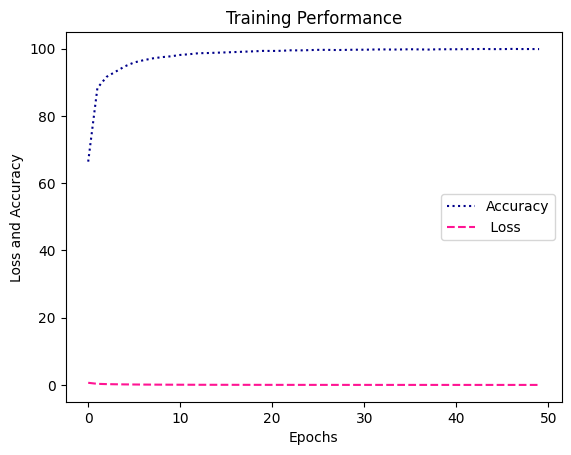

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(plot_trainacc, label='Accuracy', color='darkblue', linestyle='dotted')
plt.plot(plot_trainloss, label=' Loss', color='deeppink', linestyle='dashed')
plt.title('Training Performance')
plt.legend()
plt.show()

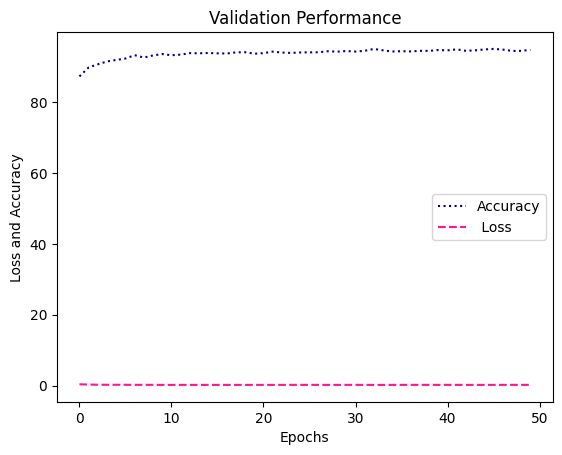

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(plot_valacc, label='Accuracy', color='darkblue', linestyle='dotted')
plt.plot(plot_valloss, label=' Loss', color='deeppink', linestyle='dashed')
plt.title('Validation Performance')
plt.legend()
plt.show()

In [ ]:
test_total = 0
test_correct = 0
test_loss = []
test_acc = []

for i, (data, labl) in enumerate(test_loader):
     with torch.no_grad():
        model.eval()
                
        data, labl = data.cuda(), labl.cuda()
        pred = model(data)
        loss = criterion(pred, labl)
        test_loss.append(loss.item())
        _, predicted = torch.max(pred.data, 1)
        test_total += labl.size(0)
        test_correct += predicted.eq(labl.data).cpu().sum()
        test_acc.append(( test_correct / test_total) * 100)

In [ ]:
print("loss:", np.mean(test_loss))
print('Accuracy', np.mean(test_acc))

loss: 0.20973228251188994
Accuracy 94.98182


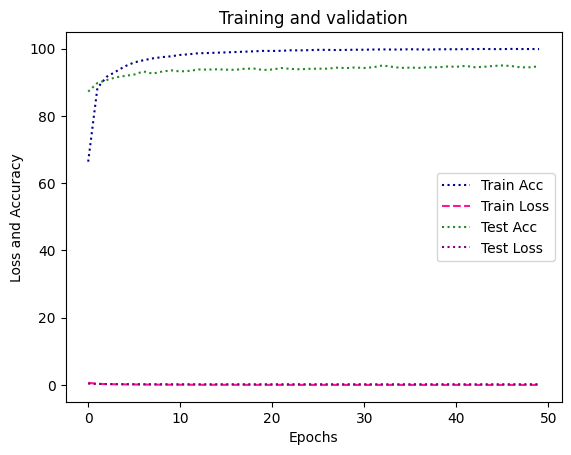

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(plot_trainacc, label='Train Acc', color='darkblue', linestyle='dotted')
plt.plot(plot_trainloss, label='Train Loss', color='deeppink', linestyle='dashed')
plt.plot(plot_valacc, label='Test Acc', color='forestgreen', linestyle='dotted')
plt.plot(plot_valloss, label='Test Loss', color='purple', linestyle='dotted')
plt.title('Training and validation')
plt.legend()
plt.show()


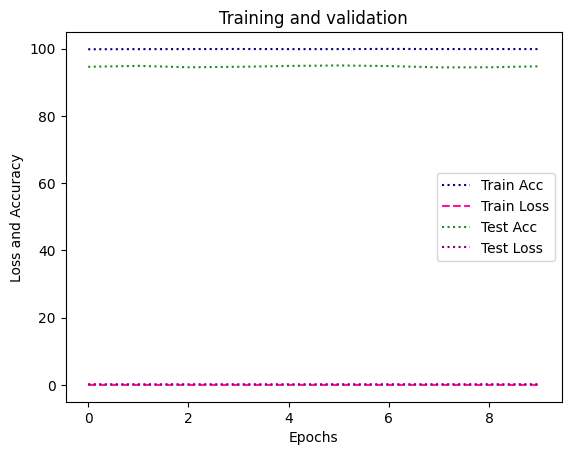

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(plot_trainacc[-10:], label='Train Acc', color='darkblue', linestyle='dotted')
plt.plot(plot_trainloss[-10:], label='Train Loss', color='deeppink', linestyle='dashed')
plt.plot(plot_valacc[-10:], label='Test Acc', color='forestgreen', linestyle='dotted')
plt.plot(plot_valloss[-10:], label='Test Loss', color='purple', linestyle='dotted')
plt.title('Training and validation')
plt.legend()
plt.show()

In [ ]:
#confusion matrix
#acc improvement 